In [17]:
import os
import cv2
import glob
import math
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
INT_S2_DIR = sorted([d for d in glob.glob("_intermediate/stage2_plantdoc/*") if os.path.isdir(d)])[-1]

In [19]:
INT_S2_DIR

'_intermediate/stage2_plantdoc/2024_12_06_19_30_57'

In [20]:
names = [d for d in os.listdir(INT_S2_DIR) if os.path.isdir(os.path.join(INT_S2_DIR, d))]

In [21]:
names

['(SAM + Inception) + (AlexNet)',
 '(SAM + YOLOv8) + (InceptionV3)',
 '(SAM + YOLOv8) + (ResNet152V2)',
 '(SAM + ResNet) + (ResNet152V2)',
 '(SAM + ResNet) + (InceptionV3)',
 '(SAM + YOLOv8) + (AlexNet)',
 '(SAM + Inception) + (InceptionV3)',
 '(SAM + Inception) + (ResNet152V2)',
 '(SAM + ResNet) + (AlexNet)']

In [22]:
def select_leaves_area_k(data, k=1, offset=0):
    preds, masks = data
    ma_all = sorted(range(len(masks)), key=lambda k: masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])
    if offset == 0:
        ma_index = ma_all[-k:]
    else:
        ma_index = ma_all[-(k+offset):-offset]
    if k >= len(ma_all):
        ma_index = ma_all
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [23]:
def select_leaves_area(data, threshold=1_280):
    preds, masks = data
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > threshold]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [24]:
def select_leaves_area_relative(data, ratio):
    preds, masks = data
    if len(masks) == 0:
        return preds, masks
    image_area = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > image_area * ratio]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [25]:
def select_leaves_all(data):
    preds, masks = data
    return preds, masks

In [26]:
def select_leaves_probability_k(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    ma_index = sorted(range(len(masks)), key=lambda k: masks[k]['leaf_probability'])[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [27]:
def select_leaves_probability(data, threshold=.9):
    masks = []
    preds = []
    for i, mask in enumerate(data[1]):
        if 'leaf_probability' not in mask.keys():
            continue
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
        #print(mask['leaf_probability'])
        if mask['leaf_probability'] < threshold:
            continue
        masks.append(mask)
        preds.append(data[0][i])
    return preds, masks

In [28]:
def select_leaves_combined(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    def score(k):
        return math.sqrt(math.sqrt(masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])) * masks[k]['leaf_probability']
    ma_index = sorted(range(len(masks)), key=score)[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [29]:
def select_leaves_sharpness_k(data, k=3):
    preds, masks = data
    def score(index):
        array = cv2.cvtColor(masks[index]['patch'], cv2.COLOR_RGB2GRAY)
        gy, gx = np.gradient(array)
        mask = array > 0
        gnorm = np.sqrt((gx * mask)**2 + (gy * mask)**2)
        sharpness = np.average(gnorm)
        return sharpness
    ma_index = sorted(range(len(masks)), key=score, reverse=True)[:k]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [ ]:
k = 3
fig, axes = plt.subplots(len(names), k, figsize=(15, 5 * len(names)))  # Adjust figure size
axes = np.array(axes).reshape(len(names), k)  # Ensure axes are in a 2D array if len(names) == 1

# Sample a single image_id to be used across all iterations
with open(os.path.join(INT_S2_DIR, names[0], "data.pkl"), "rb") as file:
    first_result = pickle.load(file)
image_id = random.sample(list(first_result.keys()), k=1)[0]
del first_result

for axs, name in zip(axes, names):
    print(name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    print(len(result[image_id]['masks']))
    # Use the pre-selected image_id
    selected = (result[image_id]['predictions'], result[image_id]['masks'])
    selected = select_leaves_probability((result[image_id]['predictions'], result[image_id]['masks']), .95)
    selected = select_leaves_area_k(selected, k=6, offset=1)
    selected = select_leaves_sharpness_k(selected, 2)
    amount = len(selected[0])
    print(selected[0])
    print(result[image_id]['healthy'])

    # Draw subplots
    for ax, (prob, mask) in zip(axs, zip(selected[0], selected[1])):
        ax.imshow(mask['patch'])
        ax.axis('off')
        ax.set_title(f"{name}: {prob}")
    # Set title for each subfigure

plt.tight_layout()
plt.show()

In [64]:
import itertools
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pickle
import os

# Define the ranges for hyperparameters
hyperparameter_space = {
    'DISEASED_THRESHOLD_SINGLE': [0.8, 0.85, 0.9, 0.925, 0,9375, 0.95],
    'MIN_LEAF_PROBABILITY': [0.8, 0.85, 0.9, 0.925, 0,9375, 0.95],
    'N_SELECT_AREA': [2, 3, 4],
    'OFFSET_SELECT_AREA': [0, 1],
    'N_SELECT_SHARPNESS': [2, 3, 4],
}

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(*hyperparameter_space.values()))

# DataFrame to log scores
log_df = pd.DataFrame(columns=list(hyperparameter_space.keys()) + ['name', 'auc'])

# To store the best configuration
best_config = None
best_auc = -1
best_name = None

p_bar = tqdm(names)
# Process each dataset separately to reduce memory usage
for name in p_bar:
    p_bar.set_description(f"Processing {name}")
    try:
        # Unpickle data for the current file
        with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
            result = pickle.load(file)
        
        # Iterate over hyperparameter combinations
        for combo in hyperparameter_combinations:
            # Assign the hyperparameters
            params = dict(zip(hyperparameter_space.keys(), combo))
            DISEASED_THRESHOLD_SINGLE = params['DISEASED_THRESHOLD_SINGLE']
            MIN_LEAF_PROBABILITY = params['MIN_LEAF_PROBABILITY']
            N_SELECT_AREA = params['N_SELECT_AREA']
            OFFSET_SELECT_AREA = params['OFFSET_SELECT_AREA']
            N_SELECT_SHARPNESS = params['N_SELECT_SHARPNESS']
            
            # Initialize results for the current combination
            results_conv = {'y_true': [], 'y_pred': []}
            for image_id, data in result.items():
                if len(data['masks']) == 0:
                    continue
                selected = (data['predictions'], data['masks'])
                selected = select_leaves_probability(selected, MIN_LEAF_PROBABILITY)
                selected = select_leaves_area_k(selected, k=N_SELECT_AREA, offset=OFFSET_SELECT_AREA)
                selected = select_leaves_sharpness_k(selected, N_SELECT_SHARPNESS)
                for pred, mask in zip(selected[0], selected[1]):
                    results_conv['y_pred'].append(int(mask['prob_diseased'] > DISEASED_THRESHOLD_SINGLE))
                    results_conv['y_true'].append(1 - int(data['healthy']))
            
            # Skip if no results are available
            if len(results_conv['y_true']) == 0:
                continue
            
            # Calculate AUC for the current combination
            try:
#                print(results_conv)
                auc = roc_auc_score(results_conv['y_true'], results_conv['y_pred'])
                log_df = pd.concat([log_df, pd.DataFrame([{**params, 'name': name, 'auc': auc}])], ignore_index=True)
                if auc > best_auc:
                    best_auc = auc
                    best_config = params
                    best_name = name
            except Exception as e:
                print(f"Error calculating AUC for {name} with {params}: {e}")
                continue
    except Exception as e:
        print(f"Error processing file {name}: {e}")
        continue

# Save results to CSV
log_df.to_csv("hyperparameter_search_log.csv", index=False)

# Print the best configuration and its AUC
print(f"Best Configuration: {best_config}")
print(f"Best AUC: {best_auc}")
print(f"Best Name: {best_name}")

Processing (SAM + Inception) + (AlexNet):   0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_753574/1815435888.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([{**params, 'name': name, 'auc': auc}])], ignore_index=True)
Processing (SAM + ResNet) + (AlexNet): 100%|██████████| 9/9 [1:20:50<00:00, 538.99s/it]       

Best Configuration: {'DISEASED_THRESHOLD_SINGLE': 0.95, 'MIN_LEAF_PROBABILITY': 0.95, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}
Best AUC: 0.8333333333333334
Best Name: (SAM + Inception) + (AlexNet)


In [39]:
results_conv = {}
DISEASED_THRESHOLD = 2.8
DISEASED_THRESHOLD_SINGLE = .95
MIN_LEAF_PROBABILITY = .95
N_SELECT_AREA = 2
OFFSET_SELECT_AREA = 0
N_SELECT_SHARPNESS = 2

df = pd.read_csv("hyperparameter_search_log.csv")
# Find the best configuration for each model

print(df.columns)

best_configs_df = df.loc[df.groupby('name')['auc'].idxmax()]

# Convert to dictionary format
best_configs = best_configs_df.set_index('name').drop(columns=['auc']).to_dict(orient='index')

p_bar = tqdm(names)
results_conv = {}

for name in p_bar:
    # Fetch the best hyperparameters for the current model
    if name in best_configs:
        config = best_configs[name]
        print("using config", config)
        DISEASED_THRESHOLD_SINGLE = config["DISEASED_THRESHOLD_SINGLE"]
        MIN_LEAF_PROBABILITY = config["MIN_LEAF_PROBABILITY"]
        N_SELECT_AREA = config["N_SELECT_AREA"]
        OFFSET_SELECT_AREA = config["OFFSET_SELECT_AREA"]
        N_SELECT_SHARPNESS = config["N_SELECT_SHARPNESS"]
    else:
        print(f"No best configuration found for {name}, using defaults.")
        continue

    p_bar.set_description("Unpickling " + name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    p_bar.set_description("Converting " + name)
    results_conv[name] = {
        'y_true': [],
        'y_pred': []
    }
    for image_id, data in result.items():
        if len(data['masks']) == 0:
            continue
        selected = (data['predictions'], data['masks'])
        selected = select_leaves_probability((result[image_id]['predictions'], result[image_id]['masks']), MIN_LEAF_PROBABILITY)
        selected = select_leaves_area_k(selected, k=N_SELECT_AREA, offset=OFFSET_SELECT_AREA)
        selected = select_leaves_sharpness_k(selected, N_SELECT_SHARPNESS)
        for pred, mask in zip(selected[0], selected[1]):
            results_conv[name]['y_pred'].append(int(mask['prob_diseased'] > DISEASED_THRESHOLD_SINGLE))
            results_conv[name]['y_true'].append(1 - int(data['healthy']))
    if len(results_conv[name]['y_true']) == 0:
        print(f"{name} has no results")
        del results_conv[name]
    del result

Index(['DISEASED_THRESHOLD_SINGLE', 'MIN_LEAF_PROBABILITY', 'N_SELECT_AREA',
       'OFFSET_SELECT_AREA', 'N_SELECT_SHARPNESS', 'name', 'auc'],
      dtype='object')


Unpickling (SAM + Inception) + (AlexNet):   0%|          | 0/9 [00:00<?, ?it/s]

using config {'DISEASED_THRESHOLD_SINGLE': 0.95, 'MIN_LEAF_PROBABILITY': 0.95, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + YOLOv8) + (InceptionV3):  11%|█         | 1/9 [00:05<00:47,  5.99s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.925, 'MIN_LEAF_PROBABILITY': 0.95, 'N_SELECT_AREA': 4, 'OFFSET_SELECT_AREA': 1, 'N_SELECT_SHARPNESS': 4}


Unpickling (SAM + YOLOv8) + (ResNet152V2):  22%|██▏       | 2/9 [00:18<01:08,  9.80s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.0, 'MIN_LEAF_PROBABILITY': 0.9, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + ResNet) + (ResNet152V2):  33%|███▎      | 3/9 [00:35<01:17, 12.93s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.0, 'MIN_LEAF_PROBABILITY': 0.0, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + ResNet) + (InceptionV3):  44%|████▍     | 4/9 [00:53<01:14, 14.94s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.925, 'MIN_LEAF_PROBABILITY': 0.0, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + YOLOv8) + (AlexNet):  56%|█████▌    | 5/9 [01:10<01:02, 15.74s/it]    

using config {'DISEASED_THRESHOLD_SINGLE': 0.0, 'MIN_LEAF_PROBABILITY': 0.9, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + Inception) + (InceptionV3):  67%|██████▋   | 6/9 [01:25<00:46, 15.60s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.925, 'MIN_LEAF_PROBABILITY': 0.0, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + Inception) + (ResNet152V2):  78%|███████▊  | 7/9 [01:42<00:32, 16.05s/it]

using config {'DISEASED_THRESHOLD_SINGLE': 0.9, 'MIN_LEAF_PROBABILITY': 0.9, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Unpickling (SAM + ResNet) + (AlexNet):  89%|████████▉ | 8/9 [01:58<00:15, 15.94s/it]       

using config {'DISEASED_THRESHOLD_SINGLE': 0.0, 'MIN_LEAF_PROBABILITY': 0.0, 'N_SELECT_AREA': 2, 'OFFSET_SELECT_AREA': 0, 'N_SELECT_SHARPNESS': 2}


Converting (SAM + ResNet) + (AlexNet): 100%|██████████| 9/9 [02:14<00:00, 14.91s/it]


In [40]:
for name, data in results_conv.items():
    print(name, len(data['y_pred']))

(SAM + Inception) + (AlexNet) 4
(SAM + YOLOv8) + (InceptionV3) 1552
(SAM + YOLOv8) + (ResNet152V2) 1014
(SAM + ResNet) + (ResNet152V2) 1023
(SAM + ResNet) + (InceptionV3) 1023
(SAM + YOLOv8) + (AlexNet) 1014
(SAM + Inception) + (InceptionV3) 1023
(SAM + Inception) + (ResNet152V2) 5
(SAM + ResNet) + (AlexNet) 1023


In [23]:
import pickle
with open(os.path.join("_intermediate", "results_conv_masked.pkl"), "wb+") as file:
          pickle.dump(results_conv, file)

In [24]:
import pickle
with open(os.path.join("_intermediate", "results_conv.pkl"), "rb") as file:
        results_conv = pickle.load(file)

In [43]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in results_conv.items():
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    report = classification_report(data['y_true'], data['y_pred'], sample_weight=sample_weight, output_dict=True)['weighted avg']
    del report['support']
    report['accuracy'] = balanced_accuracy_score(data['y_true'], data['y_pred'], sample_weight=sample_weight)
    report['auc'] = roc_auc_score(data['y_true'], data['y_pred'])
    
    report_df.loc[name] = list(report.values())

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [44]:
report_df

,precision,recall,f1-score,accuracy,auc
(SAM + Inception) + (AlexNet),0.875000,0.833333,0.828571,0.833333,0.833333
(SAM + YOLOv8) + (InceptionV3),0.614861,0.593921,0.574530,0.593921,0.593921
(SAM + YOLOv8) + (ResNet152V2),0.250000,0.500000,0.333333,0.500000,0.500000
(SAM + ResNet) + (ResNet152V2),0.250000,0.500000,0.333333,0.500000,0.500000
(SAM + ResNet) + (InceptionV3),0.581369,0.525978,0.428763,0.525978,0.525978
(SAM + YOLOv8) + (AlexNet),0.250000,0.500000,0.333333,0.500000,0.500000
(SAM + Inception) + (InceptionV3),0.581369,0.525978,0.428763,0.525978,0.525978
(SAM + Inception) + (ResNet152V2),0.250000,0.500000,0.333333,0.500000,0.500000
(SAM + ResNet) + (AlexNet),0.250000,0.500000,0.333333,0.500000,0.500000


In [45]:
report_df.to_csv("report_individual_hyperparameters.csv", index=False)

In [46]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & precision & recall & f1-score & accuracy & auc \\\\\n\\midrule\n(SAM + Inception) + (AlexNet) & 0.8750 & 0.8333 & 0.8286 & 0.8333 & 0.8333 \\\\\n(SAM + YOLOv8) + (InceptionV3) & 0.6149 & 0.5939 & 0.5745 & 0.5939 & 0.5939 \\\\\n(SAM + YOLOv8) + (ResNet152V2) & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n(SAM + ResNet) + (ResNet152V2) & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n(SAM + ResNet) + (InceptionV3) & 0.5814 & 0.5260 & 0.4288 & 0.5260 & 0.5260 \\\\\n(SAM + YOLOv8) + (AlexNet) & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n(SAM + Inception) + (InceptionV3) & 0.5814 & 0.5260 & 0.4288 & 0.5260 & 0.5260 \\\\\n(SAM + Inception) + (ResNet152V2) & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n(SAM + ResNet) + (AlexNet) & 0.2500 & 0.5000 & 0.3333 & 0.5000 & 0.5000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [51]:
report_df = report_df[report_df['auc'] > .5]

4


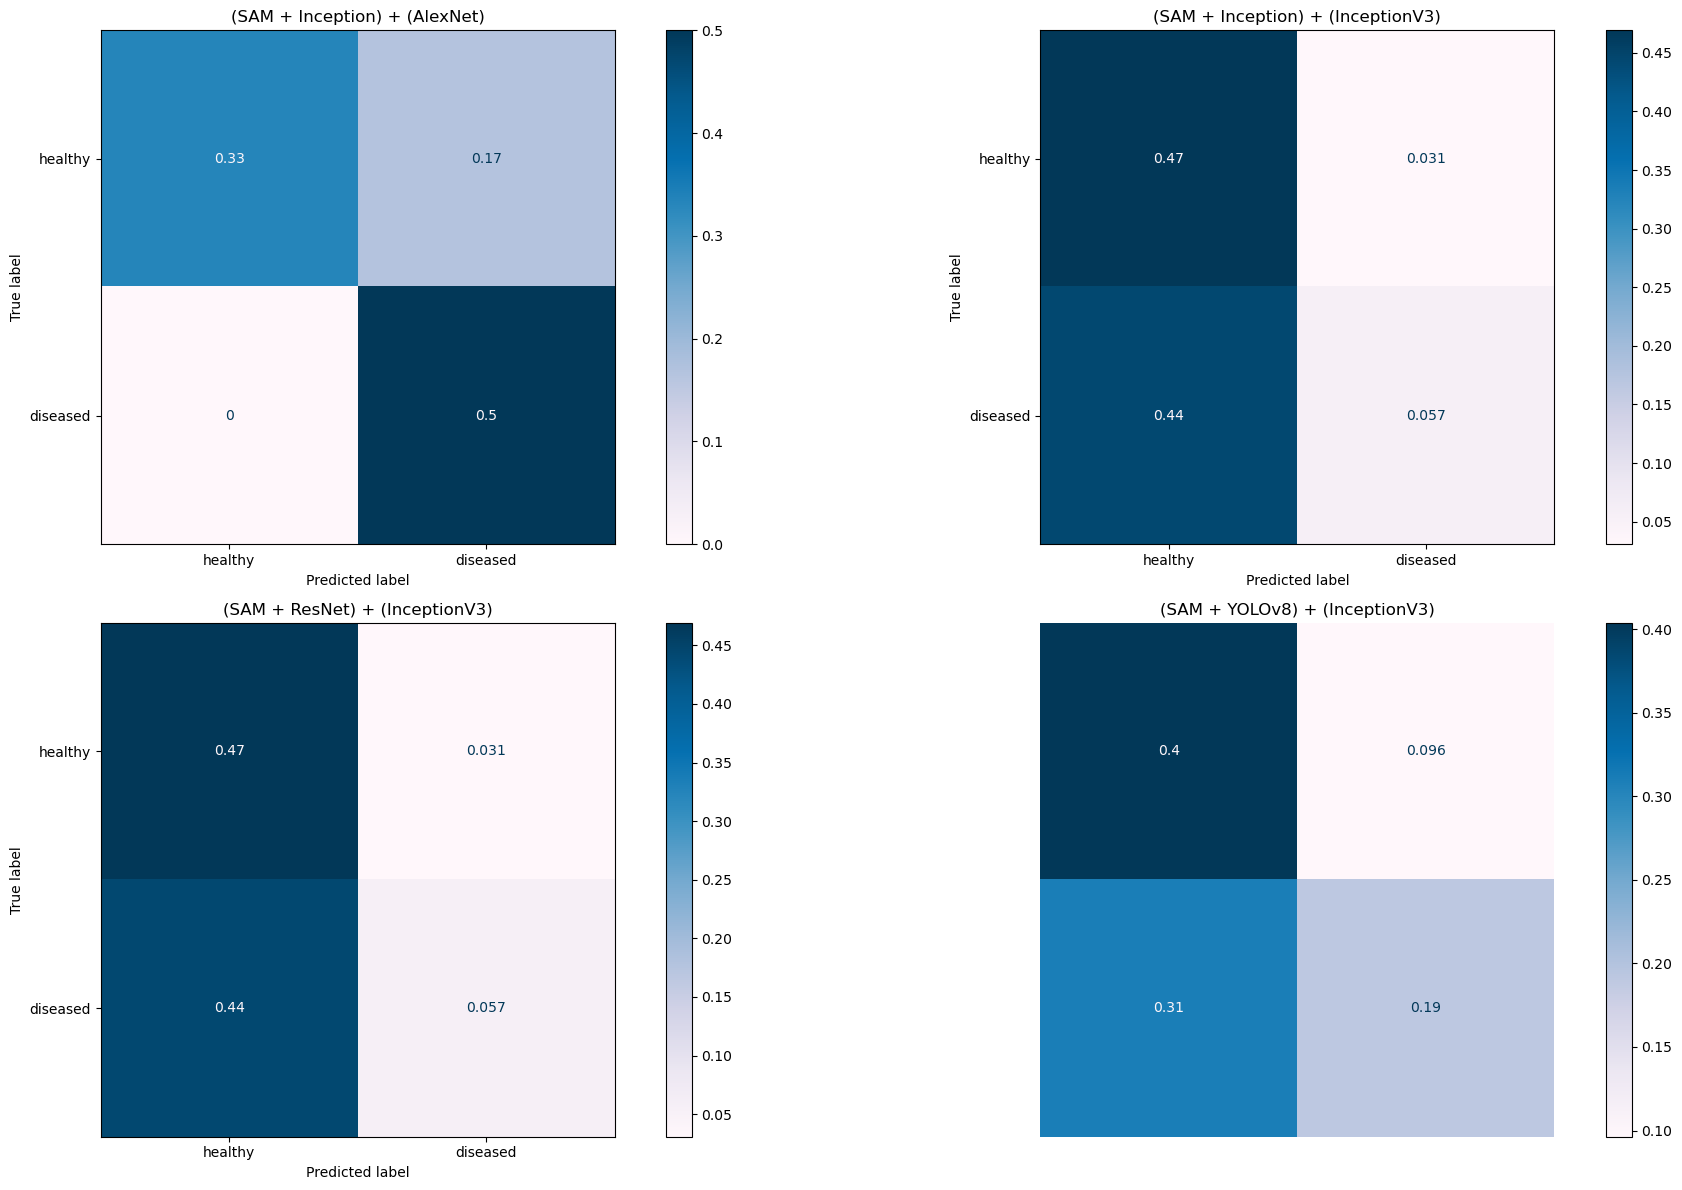

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

results_conv_sel = {key: value for key, value in results_conv.items() if key in report_df.index}
print(len(results_conv_sel))

cols = 2
fig, axes = plt.subplots((len(results_conv_sel) // cols), cols, figsize=(20, 12))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, sorted(results_conv_sel.items())):
    total = len(data['y_true'])
    if total == 0:
        continue
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    disp = ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'],
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   sample_weight=sample_weight, 
                                                   normalize='all',
                                                   display_labels=["healthy", 'diseased'])
    disp.ax_.set_title(name)
plt.tight_layout()
plt.show()

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaled_df = pd.DataFrame(scaler.fit_transform(report_df), columns=report_df.columns, index=report_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = report_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'Pipeline'}, inplace=True)

In [53]:
scaled_df_melted

,Pipeline,Metric,Scaled Value
0,(SAM + Inception) + (AlexNet),precision,0.875000
1,(SAM + YOLOv8) + (InceptionV3),precision,0.614861
2,(SAM + ResNet) + (InceptionV3),precision,0.581369
3,(SAM + Inception) + (InceptionV3),precision,0.581369
4,(SAM + Inception) + (AlexNet),recall,0.833333
5,(SAM + YOLOv8) + (InceptionV3),recall,0.593921
6,(SAM + ResNet) + (InceptionV3),recall,0.525978
7,(SAM + Inception) + (InceptionV3),recall,0.525978
8,(SAM + Inception) + (AlexNet),f1-score,0.828571
9,(SAM + YOLOv8) + (InceptionV3),f1-score,0.574530


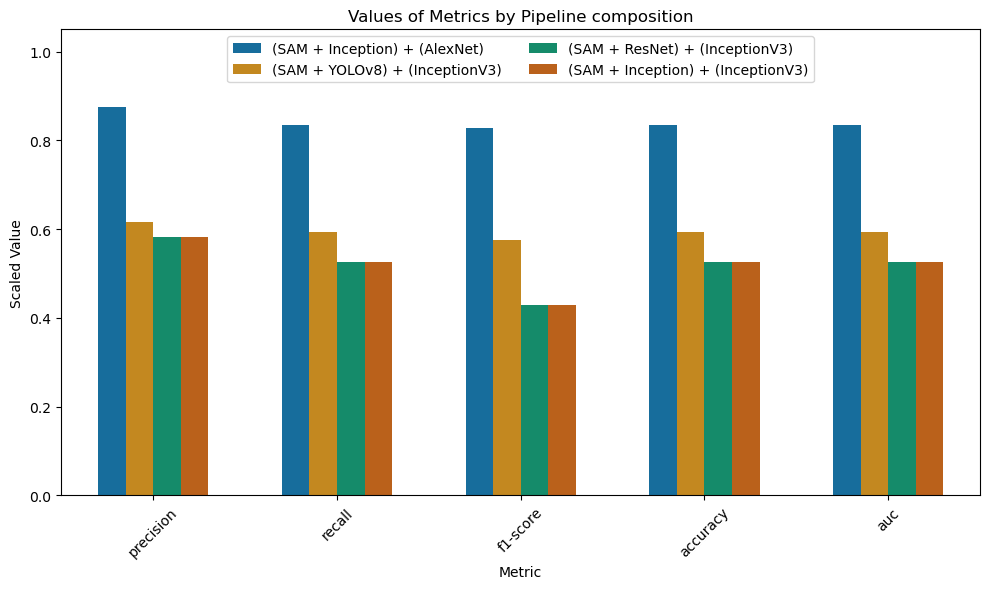

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Scaled Value', hue='Pipeline', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=2, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

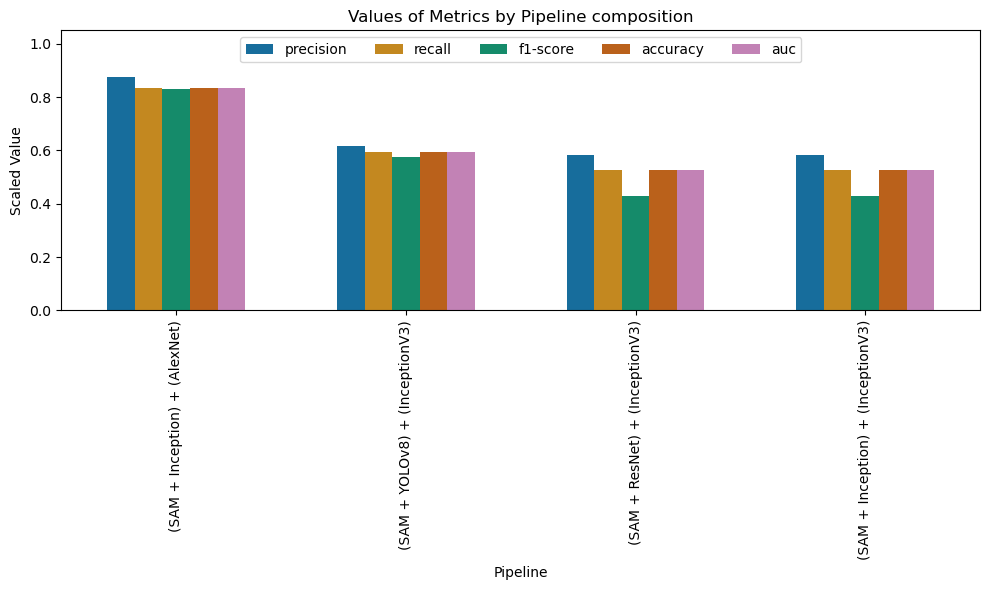

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Pipeline', y='Scaled Value', hue='Metric', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=5, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()